# Set up basic experiment to measure convergence times for theoretical setting

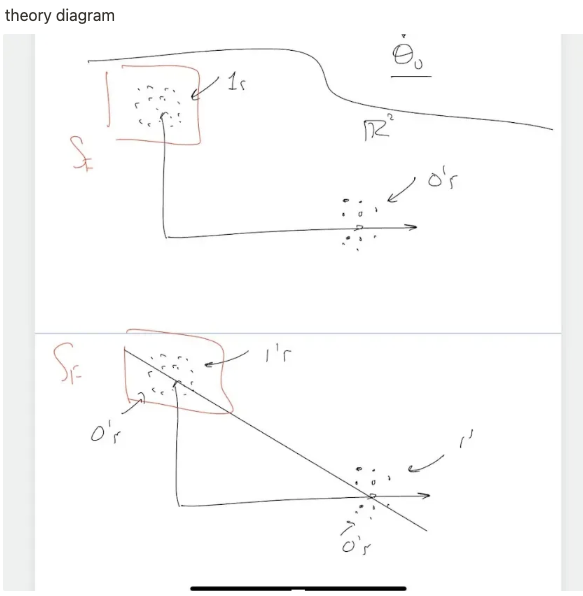

work todo:
1. set up data as above
2. produce 2 settings (above and below)
3. train Logistic regression, or SVM (something simple)
4. run Oracle Matching as an unlearning technique
5. measure of unlearning success?
    0. probability of margins 
    1. KLOM
    2. FIT?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

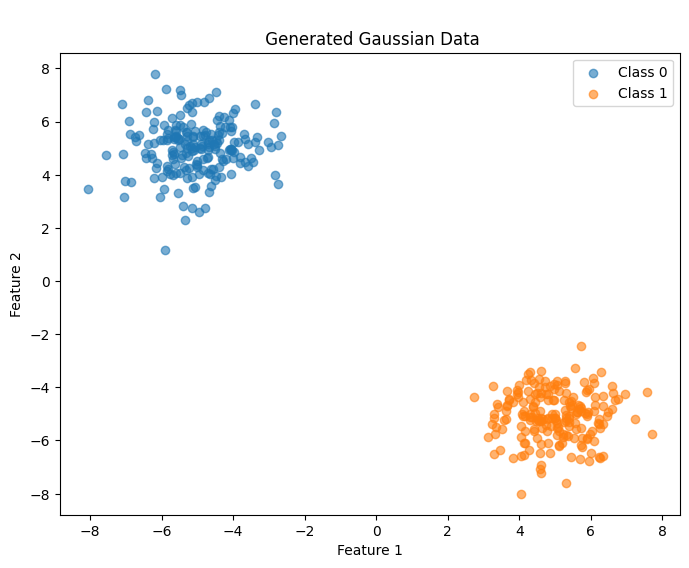

In [26]:
def generate_gaussians(n_samples=500, d=2, mean1=None, mean2=None, cov1=None, cov2=None, sigma= 1.):
    """
    Generate two Gaussian distributions with specified means and covariances.

    Args:
        n_samples (int): Number of samples to generate for each class.
        d (int): Number of dimensions for the Gaussians (default is 2).
        mean1 (array): Mean of the first Gaussian.
        mean2 (array): Mean of the second Gaussian.
        cov1 (array): Covariance matrix of the first Gaussian.
        cov2 (array): Covariance matrix of the second Gaussian.

    Returns:
        X (ndarray): Combined data from both Gaussians.
        y (ndarray): Labels for the data (0 or 1).
    """
    if mean1 is None:
        mean1 = np.zeros(d)
    if mean2 is None:
        mean2 = np.ones(d) * 2
    if cov1 is None:
        cov1 = np.eye(d) * sigma
    if cov2 is None:
        cov2 = np.eye(d) * sigma

    data1 = np.random.multivariate_normal(mean1, cov1, n_samples)
    data2 = np.random.multivariate_normal(mean2, cov2, n_samples)

    X = np.vstack((data1, data2))
    y = np.hstack((np.zeros(n_samples), np.ones(n_samples)))

    return X, y

def label_points_by_line(X,w, b):
    """
    Label points based on a linear decision boundary.

    Args:
        X (ndarray): Data points.
        w (ndarray): Weight vector for the linear decision boundary.
        b (float): Bias term for the linear decision boundary.

    Returns:
        y (ndarray): Labels for the data based on the decision boundary.
    """
    y = np.dot(X, w) + b
    y = np.where(y >= 0, 1, 0)
    print(y)
    return y


import numpy as np

def visualize_data(X, y, show = True, title = ""):
    """
    Visualize labeled data in 2D.

    Args:
        X (ndarray): Data points.
        y (ndarray): Labels for the data (0 or 1).  
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label="Class 0", alpha=0.6)
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label="Class 1", alpha=0.6)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.title(f"{title}\n Generated Gaussian Data")
    if show:
        plt.show()




#print(f"generate data")
# Generate the data
n_samples = 200
d = 2
dist = 5
mean_1 = np.array([-dist, dist])
mean_2 = np.array([dist, -dist])
X, y = generate_gaussians(n_samples=n_samples, d=d, mean1=mean_1, mean2=mean_2, )

visualize_data(X, y, show = True )

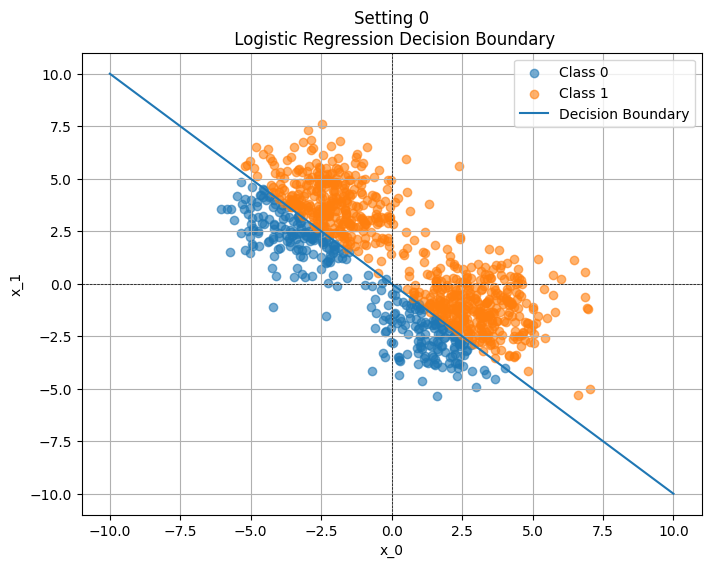

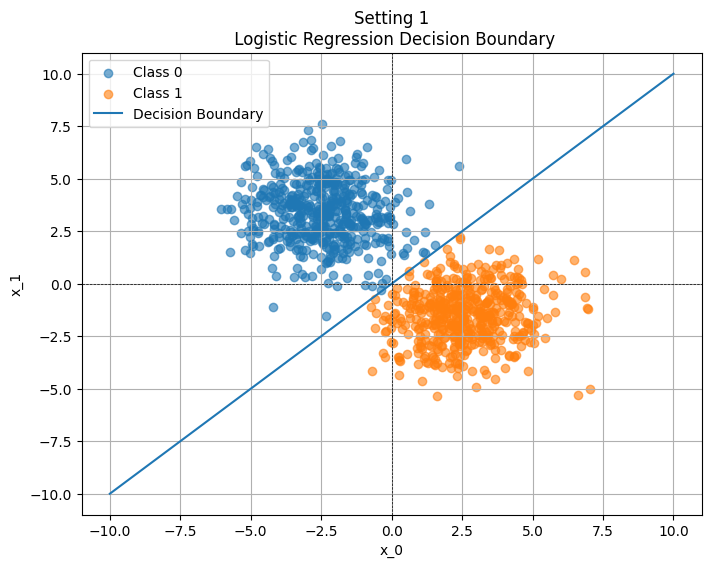

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def logistic_regression_labels(weights, X, bias=0.0):
    """
    Computes the logistic regression labels (0 or 1) for given input data X and a line defined by coefficients.

    Parameters:
        weights (numpy array): An array of coefficients corresponding to the variables x_0, x_1, ..., x_n.
        X (numpy array): A 2D array where each row is a data point, and columns correspond to the variables x_0, x_1, ..., x_n.
        bias (float, optional): The bias term b. Default is 0.0.

    Returns:
        numpy array: A 1D array of 0/1 logistic regression labels for each data point in X.
    """
    # Ensure weights and X dimensions align
    if X.shape[1] != weights.shape[0]:
        raise ValueError(f"Shape mismatch: X has {X.shape[1]} features, but weights has {weights.shape[0]} dimensions.")

    # Compute linear combination
    linear_combination = np.dot(X, weights) + bias

    # Apply the sigmoid function
    probabilities = 1 / (1 + np.exp(-linear_combination))

    # Convert probabilities to labels (0 or 1) based on a threshold of 0.5
    labels = (probabilities >= 0.5).astype(int)

    return labels

def plot_decision_boundary(weights, bias, show = True, title = ""):
    """
    Plots the decision boundary defined by the logistic regression weights and bias.

    Parameters:
        weights (numpy array): An array of coefficients corresponding to the variables x_0, x_1, ..., x_n.
        bias (float): The bias term b.
    """
    if len(weights) != 2:
        raise ValueError("This function only supports 2D data (weights must have exactly 2 elements).")

    # Generate x values for the line
    x_vals = np.linspace(-10, 10, 100)

    # Compute the corresponding y values for the decision boundary
    y_vals = -(weights[0] * x_vals + bias) / weights[1]

    # Plot the decision boundary
    plt.plot(x_vals, y_vals, label="Decision Boundary")
    plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
    plt.axvline(0, color="black", linewidth=0.5, linestyle="--")
    plt.xlabel("x_0")
    plt.ylabel("x_1")
    plt.title(f"{title}\n Logistic Regression Decision Boundary")
    plt.legend()
    plt.grid()
    if show:
        plt.show()




#print(f"generate data")
# Generate the data
n_samples = 500
d = 2
dist = 2.5
sigma = 2
bias = 1

mean_1 = np.array([-dist, dist+ bias])
mean_2 = np.array([dist, -dist+bias])

X, y = generate_gaussians(n_samples=n_samples, d=d, mean1=mean_1, mean2=mean_2,sigma=sigma )
#print(f"correct y- {y}")
weights_1 = np.array([1,1]) # y = mx + b
weights_2 = np.array([1,-1]) # y = mx + b
bias = 0
for i, weights in enumerate([weights_1, weights_2]):
    y = logistic_regression_labels(weights, X, bias)
    visualize_data(X, y, show = False )
    plot_decision_boundary(weights, bias, show = False, title = f"Setting {i}")

    plt.legend()
    plt.show()


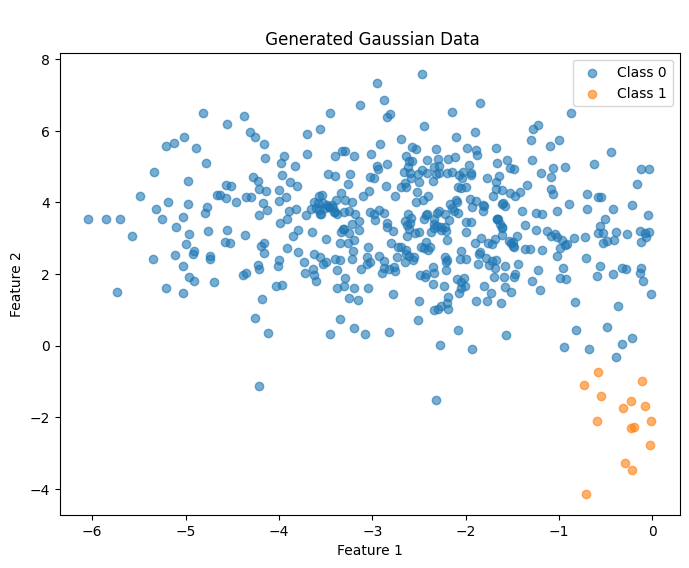

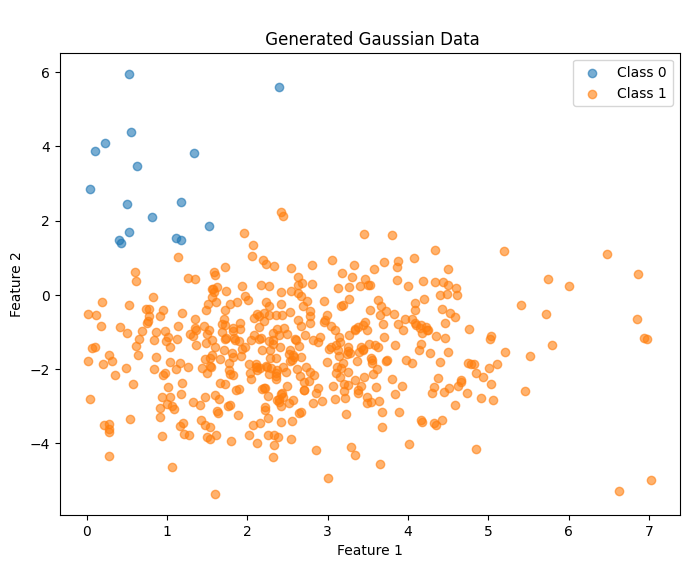

In [28]:
# forget set points are ones above 0
mask_forget = np.where(X[:, 0] > 0)
mask_retain = np.where(X[:, 0] < 0)
X_forget = X[mask_forget]
X_retain = X[mask_retain]
# plot retain 
visualize_data(X_retain, y[mask_retain], show = True )
# plot forget
visualize_data(X_forget, y[mask_forget], show = True )

In [29]:
def do_one_step_oracle_matching(model, oracle_model, retain_set, forget_set, batch_size = 32, lr = 0.01):
    raise
    forget_pt_count = batch_size //2
    retain_pt_count = batch_size //2
    # choose random forget points
    forget_indices = np.random.choice(len(forget_set), forget_pt_count, replace=False)
    forget_points = forget_set[forget_indices]
    # choose random retain points
    retain_indices = np.random.choice(len(retain_set), retain_pt_count, replace=False)
    retain_points = retain_set[retain_indices]
    # get oracle labels
    y_forget = oracle_model.predict(forget_points)
    y_retain = oracle_model.predict(retain_points)

    # TODO here - fix this to take an SGD step of the model
    #raise 
    # do SGD on the forget points with the labels from model_1
    model.fit(forget_points, y_forget)#, max_iter=1, warm_start=True)
    # do SGD on the retain points with the labels from model_2
    model.fit(retain_points, y_retain)#, max_iter=1, warm_start=True)
    return model

def distance_from_oracle(model, oracle_model, retain_points, forget_points):
    # get oracle labels
    oracle_forget = oracle_model.predict(forget_points)
    oracle_retain = oracle_model.predict(retain_points)

    # calculate distance from oracle
    forget_dist = np.mean(np.abs(oracle_forget - model.predict(forget_points)))
    retain_dist = np.mean(np.abs(oracle_retain - model.predict(retain_points)))
    return forget_dist, retain_dist


In [30]:

## Setting 1 
labels = logistic_regression_labels(weights_1, X, bias)


original_model = LogisticRegression()
original_model.fit(X, labels)
# plot X,y data
visualize_data(X, labels, show = True , title = "Setting 1")
forget_labels = logistic_regression_labels(weights_1, X_forget, bias)
visualize_data(X_forget, forget_labels, show = True , title = "Setting 1 - Forget Set")
# create a new model

# train original model and oracle
oracle_model = LogisticRegression()
oracle_model.fit(X, labels)
model = LogisticRegression()
model.fit(X, labels)
# do one step oracle matching
distances = []
retain_distances = []
forget_distances = []
steps = 50
if False:
    for i in range(steps):
        model = do_one_step_oracle_matching(model, oracle_model, X_retain, X_forget, batch_size= 2)
        # get distance from oracle
        forget_dist, retain_dist = distance_from_oracle(model, oracle_model, X_retain, X_forget)
        #print(f"forget distance - {forget_dist}")
        retain_distances.append(retain_dist)
        forget_distances.append(forget_dist)

    #plot 
    plt.plot(range(steps), forget_distances, label="Margin distance on forget set ")
    plt.plot(range(steps), retain_distances, label="Margin distance on retain set ")

    plt.xlabel("Iteration")
    plt.ylabel("Distance from Oracle")

    plt.title("Distance from Oracle vs Iteration")
    plt.legend()
    plt.show()

TypeError: LogisticRegression.__init__() missing 1 required positional argument: 'input_dim'

In [31]:


## Setting 2
labels = logistic_regression_labels(weights_2, X, bias)
original_model = LogisticRegression()
original_model.fit(X, labels)
visualize_data(X, labels, show = True , title = "Setting 2")
forget_labels = logistic_regression_labels(weights_2, X_forget, bias)
visualize_data(X_forget, forget_labels, show = True , title = "Setting 2 - Forget Set")

if False:
    # train original model and oracle
    oracle_model = LogisticRegression()
    oracle_model.fit(X, labels)
    model = LogisticRegression()
    model.fit(X, labels)
    # do one step oracle matching
    model = do_one_step_oracle_matching(model, oracle_model, X_retain, X_forget)
    # get distance from oracle
    forget_dist, retain_dist = distance_from_oracle(model, oracle_model, X_retain, X_forget)
    print(f"forget distance - {forget_dist}")

TypeError: LogisticRegression.__init__() missing 1 required positional argument: 'input_dim'

X - torch.Size([1000, 2]), y - torch.Size([1000, 1])
Epoch [1/100], Loss: 0.7808
Epoch [11/100], Loss: 1.3260
Epoch [21/100], Loss: 0.7140
Epoch [31/100], Loss: 0.4818
Epoch [41/100], Loss: 0.5279
Epoch [51/100], Loss: 0.5800
Epoch [61/100], Loss: 0.2925
Epoch [71/100], Loss: 0.3862
Epoch [81/100], Loss: 0.1659
Epoch [91/100], Loss: 0.1850


/var/folders/_k/5n658rw13cx_yy7kf5hwc1r80000gp/T/ipykernel_33498/3358424992.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  linear_combination = np.dot(X, weights) + bias
/var/folders/_k/5n658rw13cx_yy7kf5hwc1r80000gp/T/ipykernel_33498/625168763.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/var/folders/_k/5n658rw13cx_yy7kf5hwc1r80000gp/T/ipykernel_33498/625168763.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

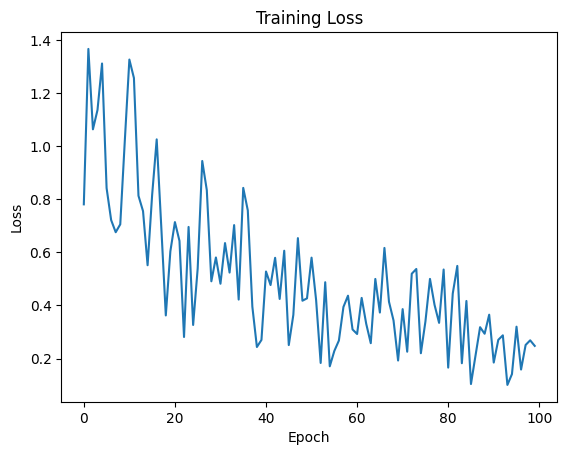

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

# Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim,device = torch.device("cpu")):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Linear layer for binary classification
        self.device = device 

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Sigmoid activation for logistic regression

# Training Method
def train_logistic_regression(model, data_loader, criterion, optimizer, epochs):
    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            # Move data to the appropriate device
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Print loss for the epoch
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
        losses.append(loss.item())
    return losses

def train_logistic_regression_direct(model, X,y, criterion, optimizer, batch_count = 100, batch_size = 32, X2 = None , y2 = None):
    losses = []
    for batch_idx in range(batch_count):
        
        # create a random batch
        if X2 is None:
            indices = np.random.choice(len(X), batch_size, replace=False)
            X_batch = X[indices]
            y_batch = y[indices]
        else:
            half_batch = batch_size // 2
            indices = np.random.choice(len(X), half_batch, replace=False)
            indices2 = np.random.choice(len(X2), half_batch, replace=False)
            X_batch = np.vstack((X[indices], X2[indices2]))
            y_batch = np.hstack((y[indices], y2[indices2]))
        # Convert to tensors

        inputs = torch.tensor(X_batch, dtype=torch.float32)
        labels = torch.tensor(y_batch, dtype=torch.float32)

        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if batch_idx % (batch_count // 10) == 0:
            # Print loss for the epoch
            print(f"Epoch [{batch_idx + 1}/{batch_count}], Loss: {loss.item():.4f}")
        losses.append(loss.item())
    return losses

# Hyperparameters
input_dim = 2  # Number of features in your dataset
learning_rate = 5e-3
epochs = 200

y = logistic_regression_labels(weights_2, X, bias)
y.shape
# y to tensor
y = torch.tensor(y)
y = y.unsqueeze(1)

y = torch.tensor(y, dtype=torch.float32)
X = torch.tensor(X, dtype=torch.float32)
print(f"X - {X.shape}, y - {y.shape}")



# Initialize model, loss function, and optimizer
model_ = LogisticRegression(input_dim=input_dim,device = torch.device("cpu"))
criterion = nn.BCELoss()
optimizer = optim.SGD(model_.parameters(), lr=learning_rate)
# Train the model
losses = train_logistic_regression_direct(model_, X,y, criterion, optimizer, batch_count = 100, batch_size = 5)
# Plot the training loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


# SCRAP extras

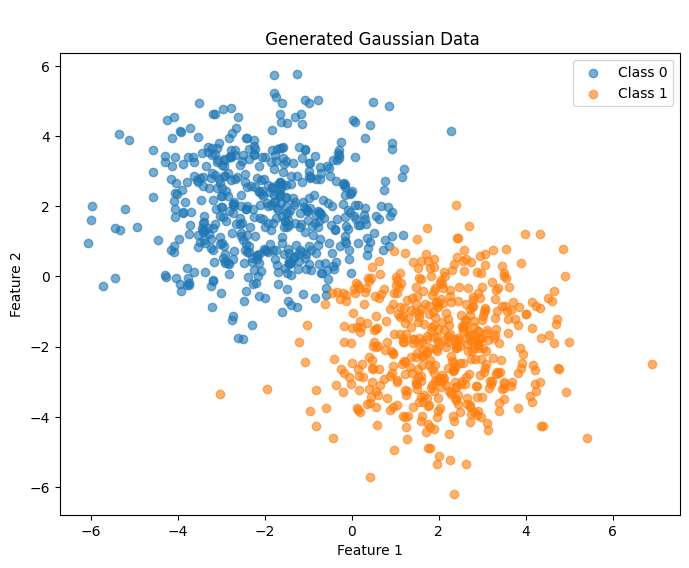

In [12]:
# plot X, y
# flatten y
y_flat = y.flatten()
visualize_data(X, y_flat, show = True )

In [13]:
dataset = torch.utils.data.TensorDataset(X, y)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

# Model, Criterion, Optimizer
model = LogisticRegression(input_dim)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Device configuration (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"train!")
# Train the model
train_logistic_regression(model, data_loader, criterion, optimizer, epochs)

train!
Epoch [1/50], Loss: 0.5599
Epoch [2/50], Loss: 0.6750
Epoch [3/50], Loss: 0.2068
Epoch [4/50], Loss: 0.2188
Epoch [5/50], Loss: 0.2747
Epoch [6/50], Loss: 0.4901
Epoch [7/50], Loss: 0.1920
Epoch [8/50], Loss: 0.2964
Epoch [9/50], Loss: 0.0831
Epoch [10/50], Loss: 0.5711
Epoch [11/50], Loss: 0.1765
Epoch [12/50], Loss: 0.3209
Epoch [13/50], Loss: 0.3058
Epoch [14/50], Loss: 0.4843
Epoch [15/50], Loss: 0.1476
Epoch [16/50], Loss: 0.3449
Epoch [17/50], Loss: 0.2516
Epoch [18/50], Loss: 0.2497
Epoch [19/50], Loss: 0.2011
Epoch [20/50], Loss: 0.4439
Epoch [21/50], Loss: 0.3424
Epoch [22/50], Loss: 0.4812
Epoch [23/50], Loss: 0.4360
Epoch [24/50], Loss: 0.2432
Epoch [25/50], Loss: 0.3201
Epoch [26/50], Loss: 0.4236
Epoch [27/50], Loss: 0.2786
Epoch [28/50], Loss: 0.1538
Epoch [29/50], Loss: 0.3085
Epoch [30/50], Loss: 0.4365
Epoch [31/50], Loss: 0.2031
Epoch [32/50], Loss: 0.3679
Epoch [33/50], Loss: 0.2039
Epoch [34/50], Loss: 0.4348
Epoch [35/50], Loss: 0.1994
Epoch [36/50], Loss: 0

[0.5598721504211426,
 0.6749721169471741,
 0.2067708969116211,
 0.21881067752838135,
 0.2747085690498352,
 0.49006009101867676,
 0.19197404384613037,
 0.2964273691177368,
 0.08314419537782669,
 0.571099042892456,
 0.17652356624603271,
 0.3209463953971863,
 0.30584120750427246,
 0.48434847593307495,
 0.1475856900215149,
 0.344933420419693,
 0.2515574097633362,
 0.24965053796768188,
 0.2010587453842163,
 0.44386765360832214,
 0.34244465827941895,
 0.481228232383728,
 0.43596863746643066,
 0.24320489168167114,
 0.3200744390487671,
 0.42363104224205017,
 0.27855461835861206,
 0.15382757782936096,
 0.30848243832588196,
 0.43650850653648376,
 0.20312032103538513,
 0.36794358491897583,
 0.20394474267959595,
 0.43483203649520874,
 0.19942452013492584,
 0.3334014117717743,
 0.16889914870262146,
 0.09762944281101227,
 0.21714019775390625,
 0.563488781452179,
 0.5582882165908813,
 0.1150989681482315,
 0.4538732171058655,
 0.5132511854171753,
 0.39891016483306885,
 0.14166943728923798,
 0.23989555

In [ ]:
dataset = torch.utils.data.TensorDataset(X, y)



# Dummy Dataset (replace with your dataset and DataLoader)
#X = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [7.0, 8.0]])
#y = torch.tensor([[0.0], [0.0], [1.0], [1.0]])  # Binary labels
data_loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

# Model, Criterion, Optimizer
model_ = LogisticRegression(input_dim)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model_.parameters(), lr=learning_rate)

# Device configuration (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_.to(device)
print(f"train!")
# Train the model
losses = train_logistic_regression(model_, data_loader, criterion, optimizer, epochs)
# plot losses
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()